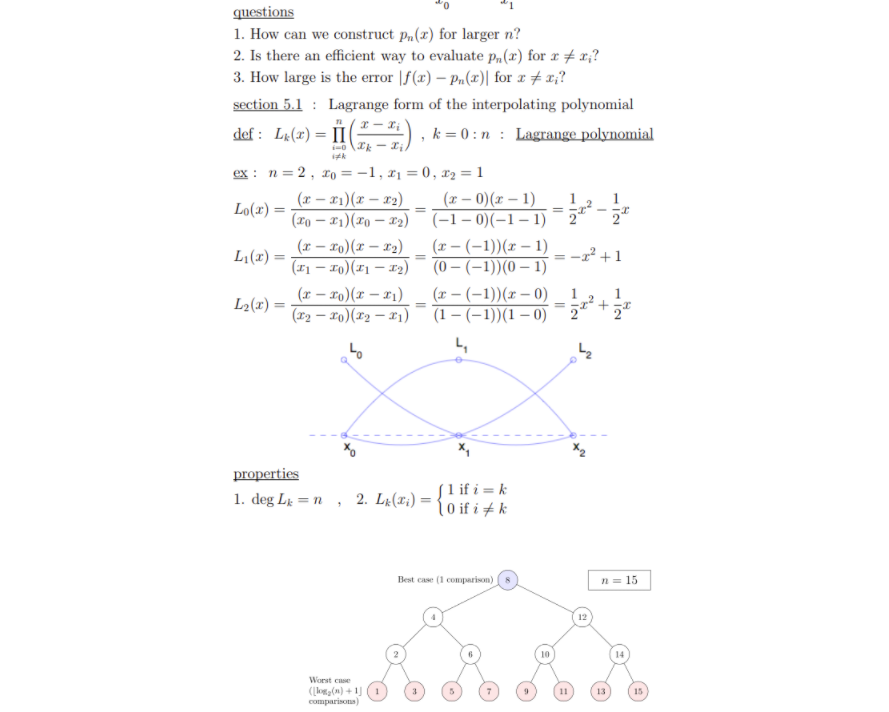

In [ ]:
import numpy as np
import sympy
from sympy import *
import pandas as pd

import plotly.express as px
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go

tips = px.data.tips()
col_options = [dict(label=x, value=x) for x in tips.columns]
# print(col_options)
dimensions = ["a","b","number of evaluations", "function"]
placeholders = ["Enter a value...", "Enter a value...", "Enter a value...", "e.g. 3 + exp(-x/2) - sin(x) + 2*cos(x)"]
value = '0'

app = dash.Dash(
    __name__, external_stylesheets=["https://codepen.io/chriddyp/pen/bWLwgP.css"]
)

app.layout = html.Div(
    [
        html.H1("Romberg Integration: Visualization"),
        html.Div(
            [
                html.P([d + ":", dcc.Input(id=d,placeholder=p,type='text',value='')])
                for d, p in zip(dimensions, placeholders)
            ],
            style={"textAlign":"right","width": "25%", "float": "left"},
        ),
        dcc.Graph(id="graph", style={"width": "75%", "display": "inline-block"}), 
        html.Table([
        html.Tr([html.Td(['Exact Value:']), html.Td(id='Exact')]),
        html.Tr([html.Td(['Trapezoidal Approximate Value:']), html.Td(id='Trap')])]
        +
        [html.Tr([html.Td([f'Romburg Apporimation Level {x+1}:']), html.Td(id=str(x+1))]) for x in range(7)]),
    ]
)

@app.callback([Output("graph", "figure"),
               Output('Exact', 'children'),
               Output('Trap', 'children')] +
              [Output(str(x+1), 'children') for x in range(7)]
              
              ,
              [Input(d, "value") for d in dimensions])

def make_figure(a, b, num_evals, func_string):
    
    def trap_method(func_string, a, b, num_evals):
        #3 + exp(-x/2) - sin(x) + 2*cos(x)
        s = func_string
        f = sympy.sympify(s)

        #eval on set of x values
        x_vals = list(np.linspace(a, b, num=num_evals))
        h = x_vals[1] - x_vals[0]
        evals_list = []
        for x in x_vals:
            y_val = f.subs({'x': x}).evalf()
            evals_list.append(y_val)
            evals_np = np.array(evals_list) 
        trap_approx = h*((evals_np[0] + evals_np[-1])*1/2 + evals_np[1:-1].sum())
        
        return x_vals, evals_np, trap_approx
    
    def romburg(f, a, b, evaluations):
        
        results = {}
        for x in range(7):
            results[f'level: {x+1}'] = ''
        
        
        #richardson extrapolation level
        # - total number of levels to the binary search tree (based on log2(n) - 1)
        # - accepting only int values
        levels = int(np.log((evaluations-1)*2)/(np.log(2)))

        # - acceptable evals given levels
        n = int((round(np.exp(levels*np.log(2)))/2)+1)
        x_vals = list(np.linspace(a, b, num=n))

        #eval on set of x values
        evals_list = []
        for x in x_vals:
            y_val = f.subs({'x': x}).evalf()
            evals_list.append(y_val)
            y_vals = np.array(evals_list)

        #step size
        h = x_vals[1] - x_vals[0]
        romburg_list1 = []

        #eval after arrangmentk
        romburg_l1 = []
        level1 = ""
        for x in range(levels-1):
            #trap1
            x_eval, evals_np, trap_approx1 = trap_method(f, a, b, n)
            #update
            x_vals = x_vals[::2]
            y_vals = y_vals[::2]
            n=len(x_vals)
            #trap2
            x_eval, evals_np, trap_approx2 = trap_method(f, a, b, n)
            romburg_apx = (4*(trap_approx1) - trap_approx2)/(3)
            romburg_l1.append(romburg_apx)
            level1 = level1 + str(romburg_apx) + ", "
        results[f'level: 1'] = level1

        romburg_next = []
        y = 2
        romburg_l1.reverse()
        while len(romburg_l1) > 1:
            y += 2
            romburg_next = []
            levelx = ""
            for x in range(len(romburg_l1)-1):
                romburg_apx = ((2**y)*(romburg_l1[x+1]) - romburg_l1[x])/((2**y)-1)
                romburg_next.append(romburg_apx)
                levelx = levelx + str(romburg_apx) + ", "
            romburg_l1 = romburg_next
            results[f'level: {int(y/2)}'] = levelx
        return results
    
    x_vals, evals_np, trap_approx = trap_method(func_string, float(a), float(b), float(num_evals))
    
    df = pd.DataFrame()
    df['x'] = x_vals
    df['y'] = list(evals_np)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(df['x']), y=(list(df['y'].astype(float))),
                    mode='lines+markers',
                    name='Trapezoidal Approximation'))
    
    # Exact Value:
    s = func_string
    f = sympy.sympify(s)
    
    true = pd.DataFrame()
    true['true_x'] = list(np.arange(float(a), float(b), 0.1))
    true['true_y'] =list(map(lambda x: f.subs({'x': x}).evalf(), true['true_x']))
    fig.add_trace(go.Scatter(x=list(true['true_x'].astype(float)), y=list(true['true_y'].astype(float)),
                        mode='lines',
                        name='Exact Value'))
    
    true_int = integrate(s)
    z1 = true_int.subs({'x': float(a)}).evalf()
    z2 = true_int.subs({'x': float(b)}).evalf()
    value = z2-z1

    results = romburg(f, float(a), float(b), float(num_evals))
    
    return fig,float(value),float(trap_approx),results['level: 1'],results['level: 2'],results['level: 3'],results['level: 4'],results['level: 5'],results['level: 6'],results['level: 7']

app.run_server(debug=False)